# Benchmarks

In [1]:
import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspologic.simulations import er_corr
from pkg.io import FIG_PATH, OUT_PATH
from pkg.io import glue as default_glue
from pkg.io import savefig
from pkg.match import GraphMatchSolver
from pkg.plot import set_theme
from tqdm import tqdm

DISPLAY_FIGS = True

FILENAME = "benchmarks"

OUT_PATH = OUT_PATH / FILENAME

FIG_PATH = FIG_PATH / FILENAME


def glue(name, var, **kwargs):
    default_glue(name, var, FILENAME, **kwargs)


def gluefig(name, fig, **kwargs):
    savefig(name, foldername=FILENAME, **kwargs)

    glue(name, fig, figure=True)

    if not DISPLAY_FIGS:
        plt.close()


t0 = time.time()
set_theme()
rng = np.random.default_rng(8888)

In [2]:
n_side = 10
glue("n_side", n_side)
n_sims = 1000
glue("n_sims", n_sims, form="long")
ipsi_rho = 0.8
glue("ipsi_rho", ipsi_rho)
ipsi_p = 0.3
glue("ipsi_p", ipsi_p)
contra_p = 0.2
glue("contra_p", contra_p)

## Seeds

In [3]:
contra_rho = 0.6
# simulate the correlated subgraphs
n_sims = 1000
rows = []
for n_seeds in [0, 1, 2, 3, 4, 5]:
    for sim in tqdm(range(n_sims)):
        if n_seeds > 0:
            seeds = np.arange(n_seeds)
            partial_match = np.stack((seeds, seeds)).T
        else:
            partial_match = None
        A, B = er_corr(n_side, ipsi_p, ipsi_rho, directed=True)
        AB, BA = er_corr(n_side, contra_p, contra_rho, directed=True)
        solver = GraphMatchSolver(A, B, verbose=0, partial_match=partial_match)
        solver.solve()
        match_ratio = (solver.permutation_ == np.arange(len(A))).mean()
        rows.append({"n_seeds": n_seeds, "match_ratio": match_ratio})
results = pd.DataFrame(rows)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 761.71it/s]


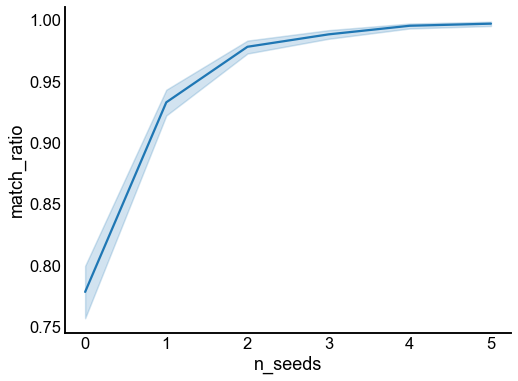

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.lineplot(data=results, x="n_seeds", y="match_ratio", ax=ax)

gluefig("accuracy_by_seeds", fig)

## Multilayer

In [5]:

# simulate the correlated subgraphs
n_sims = 1000
rows = []
for second_layer_rho in np.linspace(0, 1, 6):
    for sim in tqdm(range(n_sims)):
        A1, B1 = er_corr(n_side, ipsi_p, ipsi_rho, directed=True)
        A2, B2 = er_corr(n_side, contra_p, second_layer_rho, directed=True)
        solver = GraphMatchSolver([A1, A2], [B1, B2])
        solver.solve()
        match_ratio = (solver.permutation_ == np.arange(len(A))).mean()
        rows.append({"second_layer_rho": second_layer_rho, "match_ratio": match_ratio})
results = pd.DataFrame(rows)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 598.74it/s]


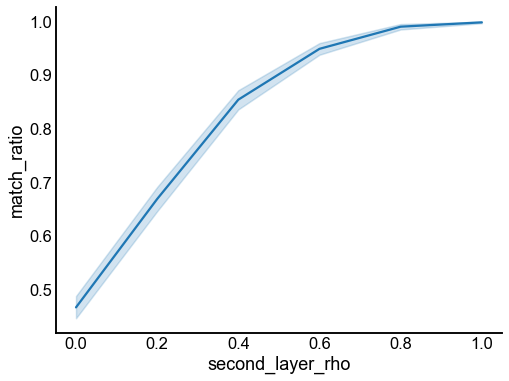

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.lineplot(data=results, x="second_layer_rho", y="match_ratio", ax=ax)

gluefig("accuracy_by_seeds", fig)

## Optimal transport

In [7]:
# REF: Figure 2B of https://arxiv.org/abs/2111.05366
n_sims = 25
n = 250
p = np.log(n) / n
rows = []
for sim in tqdm(range(n_sims)):
    A, B = er_corr(n, p, 1.0)
    perm = rng.permutation(n)
    undo_perm = np.argsort(perm)
    B = B[perm][:, perm]
    for transport in [True, False]:
        solver = GraphMatchSolver(A, B, transport=transport, transport_regularizer=200)
        solver.solve()
        match_ratio = (solver.permutation_ == undo_perm).mean()
        rows.append({"transport": transport, "match_ratio": match_ratio})
results = pd.DataFrame(rows)

  0%|                                                                                                                                                                                         | 0/25 [00:00<?, ?it/s]/Users/bpedigo/JHU_code/neuro-matching/matching/.venv/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:30<00:00,  1.21s/it]


<AxesSubplot:xlabel='transport', ylabel='match_ratio'>

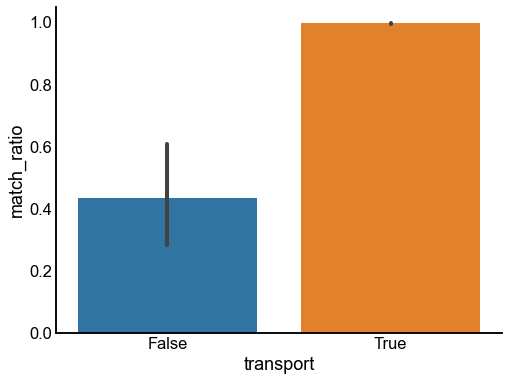

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.barplot(data=results, x="transport", y="match_ratio", ax=ax)

## Similarity

In [9]:

n_sims = 1000
rows = []
for lamb in np.linspace(0, 10, 6):
    for sim in tqdm(range(n_sims)):

        A, B = er_corr(n_side, ipsi_p, ipsi_rho, directed=True)
        S = lamb * np.eye(B.shape[0])
        perm = rng.permutation(n_side)
        undo_perm = np.argsort(perm)
        S = S[:, perm]

        solver = GraphMatchSolver(A, B, similarity=S)
        solver.solve()
        match_ratio = (solver.permutation_ == undo_perm).mean()
        rows.append({"lambda": lamb, "match_ratio": match_ratio})

results = pd.DataFrame(rows)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 769.79it/s]


<AxesSubplot:xlabel='lambda', ylabel='match_ratio'>

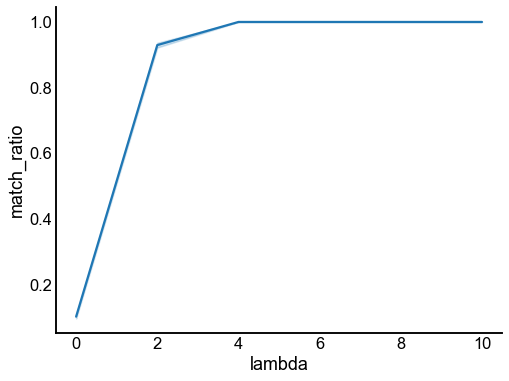

In [10]:

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.lineplot(data=results, x="lambda", y="match_ratio", ax=ax)

## End

In [11]:

elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")

Script took 0:01:07.404119
Completed at 2022-05-03 16:09:32.128742
